# Classification


**Author:**   
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 03:39 AM.</small></i>

/ \macro_output
/ \macro_code

In [1]:
%%cpp -d
#include "TMVA/Factory.h"
#include "TMVA/DataLoader.h"
#include "TMVA/Tools.h"
#include "TMVA/Classification.h"

 Arguments are defined. 

In [2]:
UInt_t jobs = 4;

In [3]:
TMVA::Tools::Instance();

TFile *input(0);
TString fname = "./tmva_class_example.root";
if (!gSystem->AccessPathName(fname)) {
   input = TFile::Open(fname); // check if file in local directory exists
} else {
   TFile::SetCacheFileDir(".");
   input = TFile::Open("http://root.cern.ch/files/tmva_class_example.root", "CACHEREAD");
}
if (!input) {
   std::cout << "ERROR: could not open data file" << std::endl;
   exit(1);
}

[TFile::Cp] Total 0.20 MB	|====================| 100.00 % [54.9 MB/s]
Info in <TFile::OpenFromCache>: using local cache copy of http://root.cern.ch/files/tmva_class_example.root [./files/tmva_class_example.root]


Register the training and test trees

In [4]:
TTree *signalTree = (TTree *)input->Get("TreeS");
TTree *background = (TTree *)input->Get("TreeB");

TMVA::DataLoader *dataloader = new TMVA::DataLoader("dataset");

If you wish to modify default settings
 (please check "src/Config.h" to see all available global options)

    (TMVA::gConfig().GetVariablePlotting()).fTimesRMS = 8.0;
    (TMVA::gConfig().GetIONames()).fWeightFileDir = "myWeightDirectory";

Define the input variables that shall be used for the mva training
 note that you may also use variable expressions, such as: "3*var1/var2*abs(var3)"
 [all types of expressions that can also be parsed by TTree::Draw( "expression" )]

In [5]:
dataloader->AddVariable("myvar1 := var1+var2", 'F');
dataloader->AddVariable("myvar2 := var1-var2", "Expression 2", "", 'F');
dataloader->AddVariable("var3", "Variable 3", "units", 'F');
dataloader->AddVariable("var4", "Variable 4", "units", 'F');

You can add so-called "spectator variables", which are not used in the mva training,
 but will appear in the final "TestTree" produced by TMVA. This TestTree will contain the
 input variables, the response values of all trained MVAs, and the spectator variables

In [6]:
dataloader->AddSpectator("spec1 := var1*2", "Spectator 1", "units", 'F');
dataloader->AddSpectator("spec2 := var1*3", "Spectator 2", "units", 'F');

Global event weights per tree (see below for setting event-wise weights)

In [7]:
Double_t signalWeight = 1.0;
Double_t backgroundWeight = 1.0;

You can add an arbitrary number of signal or background trees

In [8]:
dataloader->AddSignalTree(signalTree, signalWeight);
dataloader->AddBackgroundTree(background, backgroundWeight);

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree TreeS of type Signal with 6000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree TreeB of type Background with 6000 events


Set individual event weights (the variables must exist in the original ttree)
 -  for signal    : `dataloader->SetSignalWeightExpression    ("weight1*weight2");`
 -  for background: `dataloader->SetBackgroundWeightExpression("weight1*weight2");`

<HEADER>                          : Loading booked method: BDT BDTG
                         : 
                         : the option NegWeightTreatment=InverseBoostNegWeights does not exist for BoostType=Grad
                         : --> change to new default NegWeightTreatment=Pray
<HEADER> DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Signal     -- training events            : 1000
                         : Signal     -- testing events             : 5000
                         : Signal     -- training and testing events: 6000
                         : Background -- training events            : 1000
                         : Background -- testing events             : 5000
                         : Backgro

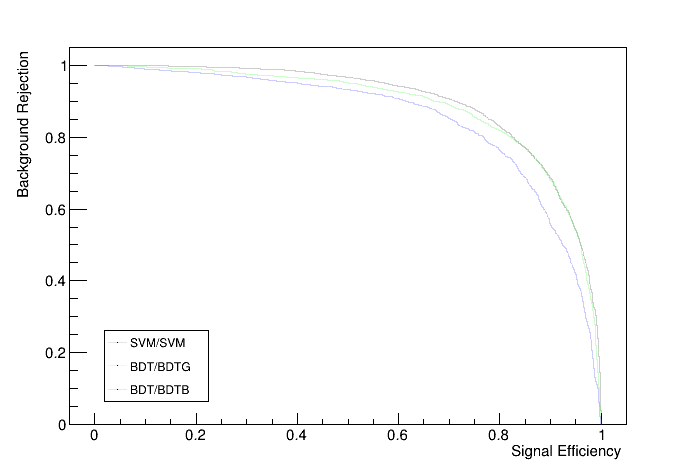

In [9]:
dataloader->SetBackgroundWeightExpression("weight");
dataloader->PrepareTrainingAndTestTree(
   "", "", "nTrain_Signal=1000:nTrain_Background=1000:SplitMode=Random:NormMode=NumEvents:!V");

TFile *outputFile = TFile::Open("TMVAClass.root", "RECREATE");

TMVA::Experimental::Classification *cl = new TMVA::Experimental::Classification(dataloader, Form("Jobs=%d", jobs));

cl->BookMethod(TMVA::Types::kBDT, "BDTG", "!H:!V:NTrees=2000:MinNodeSize=2.5%:BoostType=Grad:Shrinkage=0.10:"
                                          "UseBaggedBoost:BaggedSampleFraction=0.5:nCuts=20:MaxDepth=2");
cl->BookMethod(TMVA::Types::kSVM, "SVM", "Gamma=0.25:Tol=0.001:VarTransform=Norm");

cl->BookMethod(TMVA::Types::kBDT, "BDTB", "!H:!V:NTrees=2000:BoostType=Bagging:SeparationType=GiniIndex:nCuts=20");

cl->BookMethod(TMVA::Types::kCuts, "Cuts", "!H:!V:FitMethod=MC:EffSel:SampleSize=200000:VarProp=FSmart");

cl->Evaluate(); // Train and Test all methods

auto &results = cl->GetResults();

TCanvas *c = new TCanvas(Form("ROC"));
c->SetTitle("ROC-Integral Curve");

auto mg = new TMultiGraph();
for (UInt_t i = 0; i < results.size(); i++) {
   if (!results[i].IsCutsMethod()) {
      auto roc = results[i].GetROCGraph();
      roc->SetLineColorAlpha(i + 1, 0.1);
      mg->Add(roc);
   }
}
mg->Draw("AL");
mg->GetXaxis()->SetTitle(" Signal Efficiency ");
mg->GetYaxis()->SetTitle(" Background Rejection ");
c->BuildLegend(0.15, 0.15, 0.3, 0.3);
c->Draw();

outputFile->Close();
delete cl;